In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


[INFO] loading images...


9406464/9406464 [==============================] - 1s 0us/step
[INFO] compiling model...
[INFO] training head...


/usr/local/lib/python3.9/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Epoch 1/15
34/34 [==============================] - 29s 514ms/step - loss: 0.5370 - accuracy: 0.7603 - val_loss: 0.2150 - val_accuracy: 0.9891
Epoch 2/15
34/34 [==============================] - 14s 415ms/step - loss: 0.1979 - accuracy: 0.9597 - val_loss: 0.0891 - val_accuracy: 0.9928
Epoch 3/15
34/34 [==============================] - 14s 413ms/step - loss: 0.1164 - accuracy: 0.9747 - val_loss: 0.0557 - val_accuracy: 0.9928
Epoch 4/15
34/34 [==============================] - 14s 409ms/step - loss: 0.0871 - accuracy: 0.9813 - val_loss: 0.0442 - val_accuracy: 0.9928
Epoch 5/15
34/34 [==============================] - 14s 414ms/step - loss: 0.0579 - accuracy: 0.9888 - val_loss: 0.0323 - val_accuracy: 0.9964
Epoch 6/15
34/34 [==============================] - 14s 390ms/step - loss: 0.0515 - accuracy: 0.9906 - val_loss: 0.0293 - val_accuracy: 0.9964
Epoch 7/15
34/34 [==============================] - 14s 413ms/step - loss: 0.0439 - accuracy: 0.9944 - val_loss: 0.0248 - val_accuracy: 0.9964

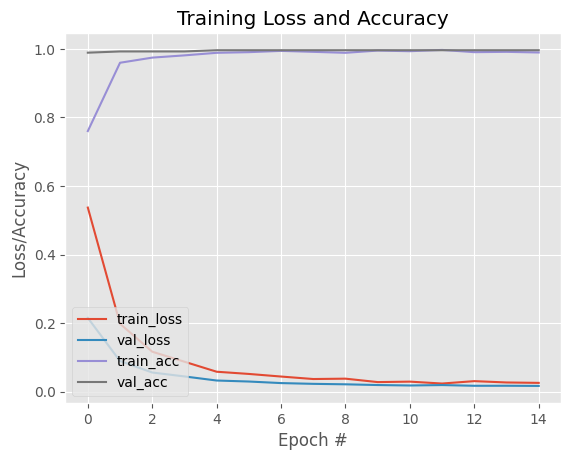

In [ ]:
# Part one - train_mask_detector.py

# import the necessary packages
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import argparse
import os

# The original file uses arguments. Here, they are replaced with the dictionary. 
# You need to replace the file path where you upload on the google driver.
dict = {'dataset': "/content/drive/My Drive/Colab Notebooks/covid19_colab/dataset", 
        'model': "/content/drive/My Drive/Colab Notebooks/covid19_colab/mask_detector.model", 
				'plot': '/content/drive/My Drive/Colab Notebooks/covid19_colab/plot.png'}

# initialize the initial learning rate, number of epochs to train for,
# and batch size
INIT_LR = 1e-4 
EPOCHS = 15 #choose wisely...
BS = 32 #change this is your dataset has less than 32 images

# grab the list of images in our dataset directory, then initialize
# the list of data (i.e., images) and class images
print("[INFO] loading images...")
imagePaths = list(paths.list_images(dict["dataset"]))
data = []
labels = []

# loop over the image paths
for imagePath in imagePaths:
	# extract the class label from the filename
	label = imagePath.split(os.path.sep)[-2]

	# load the input image (224x224) and preprocess it
	image = load_img(imagePath, target_size=(224, 224))
	image = img_to_array(image)
	image = preprocess_input(image)

	# update the data and labels lists, respectively
	data.append(image)
	labels.append(label)

# convert the data and labels to NumPy arrays
data = np.array(data, dtype="float32")
labels = np.array(labels)

# perform one-hot encoding on the labels
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)

# partition the data into training and testing splits using 75% of
# the data for training and the remaining 25% for testing
(trainX, testX, trainY, testY) = train_test_split(data, labels,
	test_size=0.20, stratify=labels, random_state=42)

# construct the training image generator for data augmentation
aug = ImageDataGenerator(
	rotation_range=20,
	zoom_range=0.15,
	width_shift_range=0.2,
	height_shift_range=0.2,
	shear_range=0.15,
	horizontal_flip=True,
	fill_mode="nearest")

# load the MobileNetV2 network, ensuring the head FC layer sets are
# left off
baseModel = MobileNetV2(weights="imagenet", include_top=False,
	input_tensor=Input(shape=(224, 224, 3)))

# construct the head of the model that will be placed on top of the
# the base model
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)

# place the head FC model on top of the base model (this will become
# the actual model we will train)
model = Model(inputs=baseModel.input, outputs=headModel)

# loop over all layers in the base model and freeze them so they will
# *not* be updated during the first training process
for layer in baseModel.layers:
	layer.trainable = False

# compile our model
print("[INFO] compiling model...")
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt,
	metrics=["accuracy"])

# train the head of the network
print("[INFO] training head...")
H = model.fit(
	aug.flow(trainX, trainY, batch_size=BS),
	steps_per_epoch=len(trainX) // BS,
	validation_data=(testX, testY),
	validation_steps=len(testX) // BS,
	epochs=EPOCHS)

# make predictions on the testing set
print("[INFO] evaluating network...")
predIdxs = model.predict(testX, batch_size=BS)

# for each image in the testing set we need to find the index of the
# label with corresponding largest predicted probability
predIdxs = np.argmax(predIdxs, axis=1)

# show a nicely formatted classification report
print(classification_report(testY.argmax(axis=1), predIdxs,
	target_names=lb.classes_))

# serialize the model to disk
print("[INFO] saving mask detector model...")
model.save(dict["model"], save_format="h5")

# plot the training loss and accuracy
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig(dict["plot"])

[INFO] loading face detector model...
[INFO] loading face mask detector model...
[INFO] computing face detections...
1/1 [==============================] - 0s 43ms/step


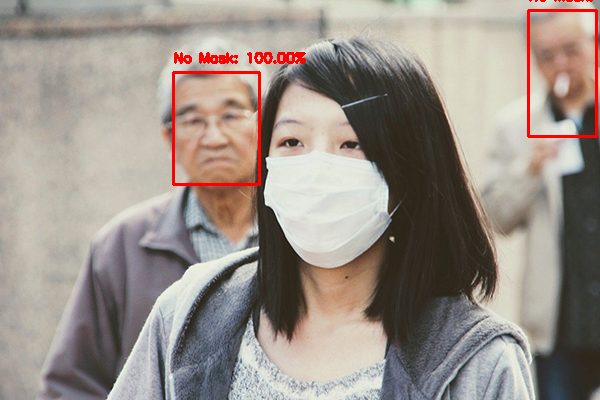

In [ ]:
# Part two - detect_mask_image.py

# import the necessary packages
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.models import load_model
from google.colab.patches import cv2_imshow
import numpy as np
import argparse
import cv2
import os

# define the path in the dict
dict = {'image': "/content/drive/My Drive/Colab Notebooks/covid19_colab/examples/example_02.png", 
        'face': "/content/drive/My Drive/Colab Notebooks/covid19_colab/face_detector", 
        'model': "/content/drive/My Drive/Colab Notebooks/covid19_colab/mask_detector.model",
        'confidence': 0.5}

# load our serialized face detector model from disk
print("[INFO] loading face detector model...")
prototxtPath = os.path.sep.join([dict["face"], "deploy.prototxt"])
weightsPath = os.path.sep.join([dict["face"],
	"res10_300x300_ssd_iter_140000.caffemodel"])
net = cv2.dnn.readNet(prototxtPath, weightsPath)

# load the face mask detector model from disk
print("[INFO] loading face mask detector model...")
model = load_model(dict["model"])

# load the input image from disk, clone it, and grab the image spatial
# dimensions
image = cv2.imread(dict["image"])
orig = image.copy()
(h, w) = image.shape[:2]

# construct a blob from the image
blob = cv2.dnn.blobFromImage(image, 1.0, (300, 300),
	(104.0, 177.0, 123.0))

# pass the blob through the network and obtain the face detections
print("[INFO] computing face detections...")
net.setInput(blob)
detections = net.forward()

# loop over the detections
for i in range(0, detections.shape[2]):
	# extract the confidence (i.e., probability) associated with
	# the detection
	confidence = detections[0, 0, i, 2]

	# filter out weak detections by ensuring the confidence is
	# greater than the minimum confidence
	if confidence > dict["confidence"]:
		# compute the (x, y)-coordinates of the bounding box for
		# the object
		box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
		(startX, startY, endX, endY) = box.astype("int")

		# ensure the bounding boxes fall within the dimensions of
		# the frame
		(startX, startY) = (max(0, startX), max(0, startY))
		(endX, endY) = (min(w - 1, endX), min(h - 1, endY))

		# extract the face ROI, convert it from BGR to RGB channel
		# ordering, resize it to 224x224, and preprocess it
		face = image[startY:endY, startX:endX]
		face = cv2.cvtColor(face, cv2.COLOR_BGR2RGB)
		face = cv2.resize(face, (224, 224))
		face = img_to_array(face)
		face = preprocess_input(face)
		face = np.expand_dims(face, axis=0)

		# pass the face through the model to determine if the face
		# has a mask or not
		(mask, withoutMask) = model.predict(face)[0]

		# determine the class label and color we'll use to draw
		# the bounding box and text
		label = "Mask" if mask > withoutMask else "No Mask"
		color = (0, 255, 0) if label == "Mask" else (0, 0, 255)

		# include the probability in the label
		label = "{}: {:.2f}%".format(label, max(mask, withoutMask) * 100)

		# display the label and bounding box rectangle on the output
		# frame
		cv2.putText(image, label, (startX, startY - 10),
			cv2.FONT_HERSHEY_SIMPLEX, 0.45, color, 2)
		cv2.rectangle(image, (startX, startY), (endX, endY), color, 2)

# show the output image
# cv2.imshow("Output", image)
# cv2.waitKey(0)
cv2_imshow(image)

In [ ]:
# Extra part - Record a video

# install extra package ffmpeg-python
!pip install ffmpeg-python


from IPython.display import HTML, Javascript, display
from google.colab.output import eval_js
from base64 import b64decode
import numpy as np
import io
import ffmpeg

# save the recorded video to the Google Driver (you need to change
# the path to where you want to save it)
video_path = '/content/drive/My Drive/Colab Notebooks/covid19_colab/examples/realtimevideo.mp4' 
  

VIDEO_HTML = """
<script>
var my_div = document.createElement("DIV");
var my_p = document.createElement("P");
var my_btn = document.createElement("BUTTON");
var my_btn_txt = document.createTextNode("Press to start recording");

my_btn.appendChild(my_btn_txt);
my_div.appendChild(my_btn);
document.body.appendChild(my_div);

var base64data = 0;
var reader;
var recorder, videoStream;
var recordButton = my_btn;

var handleSuccess = function(stream) {
  videoStream = stream;
  var options = {  
    mimeType : 'video/webm;codecs=vp9'  
  };            
  recorder = new MediaRecorder(stream, options);
  recorder.ondataavailable = function(e) {            
    var url = URL.createObjectURL(e.data);
    var preview = document.createElement('video');
    preview.controls = true;
    preview.src = url;
    document.body.appendChild(preview);

    reader = new FileReader();
    reader.readAsDataURL(e.data); 
    reader.onloadend = function() {
      base64data = reader.result;
    }
  };
  recorder.start();
  };

recordButton.innerText = "Recording... press to stop";

navigator.mediaDevices.getUserMedia({video: true}).then(handleSuccess);


function toggleRecording() {
  if (recorder && recorder.state == "recording") {
      recorder.stop();
      videoStream.getVideoTracks()[0].stop();
      recordButton.innerText = "Saving the recording... Please wait!"
  }
}

function sleep(ms) {
  return new Promise(resolve => setTimeout(resolve, ms));
}

var data = new Promise(resolve=>{
recordButton.onclick = ()=>{
toggleRecording()

sleep(2000).then(() => {
  // wait 2000ms for the data to be available
  resolve(base64data.toString())

});

}
});
      
</script>
"""

def start_webcam():
  js = Javascript('''
    async function startWebcam() {
      const div = document.createElement('div');

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);
      
      return;

    }
    ''')
  
  display(js)
  data = eval_js('startWebcam()')
  
    
start_webcam()

def get_video():
  display(HTML(VIDEO_HTML))
  data = eval_js("data")
  binary = b64decode(data.split(',')[1])
  
  return binary

videofile = get_video()
# save the video
with open(video_path, 'wb') as f:
  f.write(videofile)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


<IPython.core.display.Javascript object>

[INFO] loading face detector model...
[INFO] loading face mask detector model...
[INFO] starting video stream...
1/1 [==============================] - 1s 1s/step


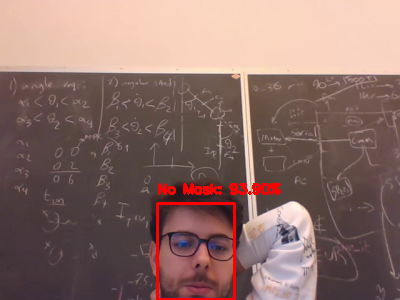

1/1 [==============================] - 0s 54ms/step


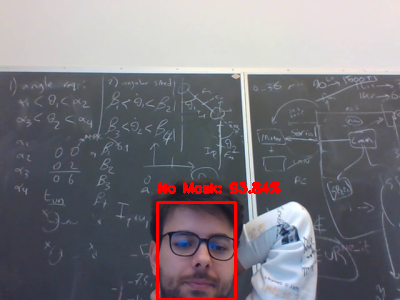

1/1 [==============================] - 0s 25ms/step


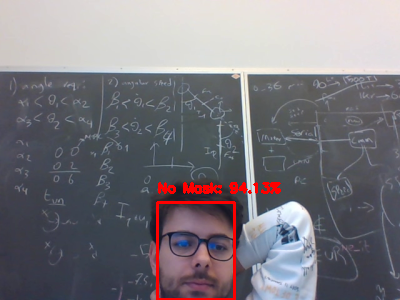

1/1 [==============================] - 0s 25ms/step


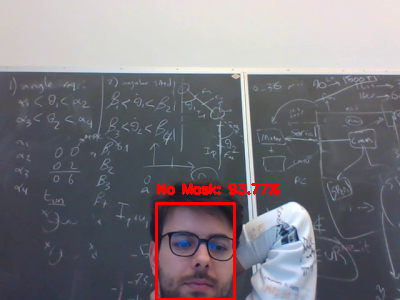

1/1 [==============================] - 0s 25ms/step


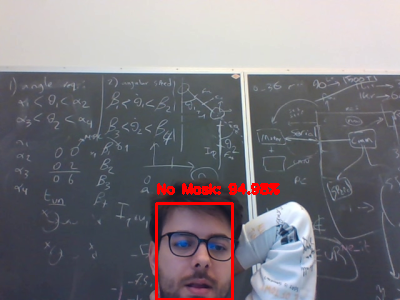

1/1 [==============================] - 0s 26ms/step


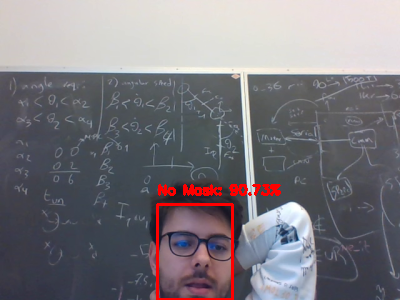

In [ ]:
# Part three - detect_mask_video.py

# import the necessary packages
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.models import load_model
from google.colab.patches import cv2_imshow

import numpy as np
import argparse
import imutils
import time
import cv2
import os

def detect_and_predict_mask(frame, faceNet, maskNet):
	# grab the dimensions of the frame and then construct a blob
	# from it
	(h, w) = frame.shape[:2]
	blob = cv2.dnn.blobFromImage(frame, 1.0, (300, 300),
		(104.0, 177.0, 123.0))

	# pass the blob through the network and obtain the face detections
	faceNet.setInput(blob)
	detections = faceNet.forward()

	# initialize our list of faces, their corresponding locations,
	# and the list of predictions from our face mask network
	faces = []
	locs = []
	preds = []

	# loop over the detections
	for i in range(0, detections.shape[2]):
		# extract the confidence (i.e., probability) associated with
		# the detection
		confidence = detections[0, 0, i, 2]

		# filter out weak detections by ensuring the confidence is
		# greater than the minimum confidence
		if confidence > dict["confidence"]:
			# compute the (x, y)-coordinates of the bounding box for
			# the object
			box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
			(startX, startY, endX, endY) = box.astype("int")

			# ensure the bounding boxes fall within the dimensions of
			# the frame
			(startX, startY) = (max(0, startX), max(0, startY))
			(endX, endY) = (min(w - 1, endX), min(h - 1, endY))

			# extract the face ROI, convert it from BGR to RGB channel
			# ordering, resize it to 224x224, and preprocess it
			face = frame[startY:endY, startX:endX]
			face = cv2.cvtColor(face, cv2.COLOR_BGR2RGB)
			face = cv2.resize(face, (224, 224))
			face = img_to_array(face)
			face = preprocess_input(face)
			face = np.expand_dims(face, axis=0)

			# add the face and bounding boxes to their respective
			# lists
			faces.append(face)
			locs.append((startX, startY, endX, endY))

	# only make a predictions if at least one face was detected
	if len(faces) > 0:
		# for faster inference we'll make batch predictions on *all*
		# faces at the same time rather than one-by-one predictions
		# in the above `for` loop
		preds = maskNet.predict(faces)

	# return a 2-tuple of the face locations and their corresponding
	# locations
	return (locs, preds)

# dictionary for parameters
dict = {'face': "/content/drive/My Drive/Colab Notebooks/covid19_colab/face_detector", 
        'model': "/content/drive/My Drive/Colab Notebooks/covid19_colab/mask_detector.model",
        'confidence': 0.5}

# load our serialized face detector model from disk
print("[INFO] loading face detector model...")
prototxtPath = os.path.sep.join([dict["face"], "deploy.prototxt"])
weightsPath = os.path.sep.join([dict["face"],
	"res10_300x300_ssd_iter_140000.caffemodel"])
faceNet = cv2.dnn.readNet(prototxtPath, weightsPath)

# load the face mask detector model from disk
print("[INFO] loading face mask detector model...")
maskNet = load_model(dict["model"])

# initialize the video stream and allow the camera sensor to warm up
print("[INFO] starting video stream...")

# where the recorded video saved
webcam = cv2.VideoCapture("/content/drive/My Drive/Colab Notebooks/covid19_colab/examples/realtimevideo.mp4")
fps = int(webcam.get(cv2.CAP_PROP_FPS))
# where the prediction results will be saved (images)
path = "/content/drive/My Drive/Colab Notebooks/covid19_colab/examples"
# grab the frame from the threaded video video
success, frame = webcam.read()
# Number of images captured of the train video
count = 0
# loop over the frames from the video stream
while success: 

	# resize frame to have a maximum width of 400 pixels  
  frame = imutils.resize(frame, width=400)

	# Check if this is the frame closest to 2 seconds 
  if count%(2*fps)==0:
	  # detect faces in the frame and determine if they are wearing a
	  # face mask or not
    (locs, preds) = detect_and_predict_mask(frame, faceNet, maskNet)

	  # loop over the detected face locations and their corresponding
	  # locations
    for (box, pred) in zip(locs, preds):
		  # unpack the bounding box and predictions
      (startX, startY, endX, endY) = box
      (mask, withoutMask) = pred

		  # determine the class label and color we'll use to draw
		  # the bounding box and text
      label = "Mask" if mask > withoutMask else "No Mask"
      color = (0, 255, 0) if label == "Mask" else (0, 0, 255)

		  # include the probability in the label
      label = "{}: {:.2f}%".format(label, max(mask, withoutMask) * 100)

		  # display the label and bounding box rectangle on the output
		  # frame
      cv2.putText(frame, label, (startX, startY - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.45, color, 2)
      cv2.rectangle(frame, (startX, startY), (endX, endY), color, 2)
		
		  # save the predicted results as png file
      cv2.imwrite('% s/% s.png' % (path, count), frame)
      cv2_imshow(frame)
      
  count += 1
	# grab the next frame from the threaded video 
  success, frame = webcam.read()

# do a bit of cleanup
cv2.destroyAllWindows()